In [1]:
import numpy as np # type: ignore
import pandas as pd # type: ignore

import matplotlib.pyplot as plt # type: ignore
import seaborn as sns # type: ignore

from sklearn.preprocessing import StandardScaler # type: ignore
from sklearn.feature_selection import SelectKBest, mutual_info_classif, SelectFromModel # type: ignore
from sklearn.linear_model import LogisticRegression # type: ignore
from sklearn.pipeline import Pipeline # type: ignore
from sklearn.model_selection import GridSearchCV, train_test_split # type: ignore
from sklearn.metrics import confusion_matrix, classification_report, make_scorer, f1_score # type: ignore
from imblearn.over_sampling import SMOTE # type: ignore
from sklearn.compose import ColumnTransformer # type: ignore
from sklearn.ensemble import ExtraTreesClassifier # type: ignore
from sklearn.svm import SVC # type: ignore
from sklearn.ensemble import RandomForestClassifier # type: ignore
from sklearn.utils.class_weight import compute_class_weight # type: ignore
from sklearn.neural_network import MLPClassifier # type: ignore
from sklearn.model_selection import GridSearchCV # type: ignore
from sklearn.neighbors import KNeighborsClassifier # type: ignore
from sklearn.inspection import permutation_importance # type: ignore

from xgboost import XGBClassifier # type: ignore

import joblib # type: ignore

In [2]:
x_train = pd.read_csv('x_train_openSmile_emobase.csv')
y_train = pd.read_csv('y_train_openSmile_emobase.csv')
x_test = pd.read_csv('x_test_openSmile_emobase.csv')
y_test = pd.read_csv('y_test_openSmile_emobase.csv')

scaler = joblib.load('scaler_openSmile_emobase.pkl')

In [3]:
selector = SelectKBest(mutual_info_classif, k=600)
selector.fit(x_train, y_train)

selected_features = x_train.columns[selector.get_support()].tolist()

print(f"Filtered down to {len(selected_features)} features.")
print(selected_features[:5])

C:\Users\jbkee\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Filtered down to 600 features.
['pcm_intensity_sma_max', 'pcm_intensity_sma_range', 'pcm_intensity_sma_amean', 'pcm_intensity_sma_linregc1', 'pcm_intensity_sma_linregc2']


C:\Users\jbkee\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1124: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


=== Happy Binary Classification Report ===
              precision    recall  f1-score   support

   not happy       0.91      0.96      0.93       530
       happy       0.72      0.54      0.62       107

    accuracy                           0.89       637
   macro avg       0.82      0.75      0.78       637
weighted avg       0.88      0.89      0.88       637



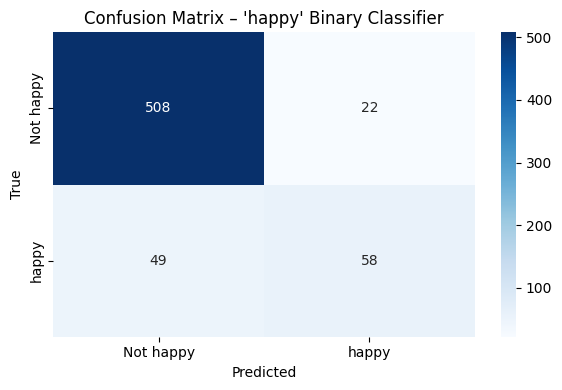

In [4]:
selector = ColumnTransformer(
  [
    ("pick_happy", "passthrough", selected_features)
  ],
  remainder="drop"
)

happy_pipe = Pipeline([
    ("select", selector),
    ("scaler", scaler),
    ("clf", MLPClassifier(
        hidden_layer_sizes=(128, 64),
        activation="relu",
        alpha=1e-3,
        learning_rate_init=1e-3,
        solver="adam",
        max_iter=1000,
        random_state=42,
        verbose=False
    ))
])

happy_pipe.fit(x_train, y_train)

y_pred = happy_pipe.predict(x_test)
print("=== Happy Binary Classification Report ===")
print(classification_report(y_test, y_pred, target_names=["not happy","happy"]))

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(
    cm, 
    annot=True, 
    fmt="d", 
    cmap="Blues",
    xticklabels=[f"Not {"happy"}", "happy"],
    yticklabels=[f"Not {"happy"}", "happy"]
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title(f"Confusion Matrix – '{"happy"}' Binary Classifier")
plt.tight_layout()
plt.show()


In [5]:
x_test_sel = x_test[selected_features]

result = permutation_importance(
    happy_pipe, 
    x_test_sel, 
    y_test, 
    scoring="f1", 
    n_repeats=10,
    random_state=42,
    n_jobs=-1
)

importances = result.importances_mean

idxs      = np.argsort(importances)[::-1]
top_n     = 150
top_idxs  = idxs[:top_n]
top_feats = [selected_features[i] for i in top_idxs]

In [6]:
print("Top 50 features by permutation importance:")
print(top_feats)

Top 50 features by permutation importance:
['voiceProb_sma_de_range', 'lspFreq_sma_de[3]_skewness', 'pcm_loudness_sma_de_maxPos', 'pcm_zcr_sma_iqr1-2', 'lspFreq_sma[2]_linregerrA', 'lspFreq_sma[2]_iqr2-3', 'mfcc_sma[7]_skewness', 'voiceProb_sma_de_linregerrQ', 'mfcc_sma[6]_skewness', 'mfcc_sma[8]_iqr2-3', 'pcm_intensity_sma_de_linregc2', 'F0_sma_iqr1-3', 'voiceProb_sma_de_stddev', 'lspFreq_sma_de[5]_minPos', 'lspFreq_sma_de[5]_amean', 'F0_sma_quartile1', 'mfcc_sma_de[12]_maxPos', 'lspFreq_sma[4]_iqr2-3', 'mfcc_sma[10]_quartile3', 'F0env_sma_iqr1-2', 'lspFreq_sma[2]_range', 'mfcc_sma_de[7]_skewness', 'mfcc_sma[2]_quartile2', 'lspFreq_sma[2]_stddev', 'mfcc_sma[9]_quartile1', 'F0env_sma_kurtosis', 'lspFreq_sma_de[1]_range', 'mfcc_sma[5]_amean', 'voiceProb_sma_de_quartile2', 'mfcc_sma[4]_min', 'lspFreq_sma[2]_amean', 'lspFreq_sma[2]_iqr1-3', 'mfcc_sma[2]_linregc1', 'lspFreq_sma_de[7]_skewness', 'mfcc_sma[8]_maxPos', 'mfcc_sma[7]_linregc1', 'lspFreq_sma_de[4]_minPos', 'mfcc_sma[1]_iqr2-3', 

C:\Users\jbkee\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1124: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


=== Happy Binary Classification Report ===
              precision    recall  f1-score   support

   not happy       0.90      0.96      0.93       530
       happy       0.68      0.46      0.55       107

    accuracy                           0.87       637
   macro avg       0.79      0.71      0.74       637
weighted avg       0.86      0.87      0.86       637



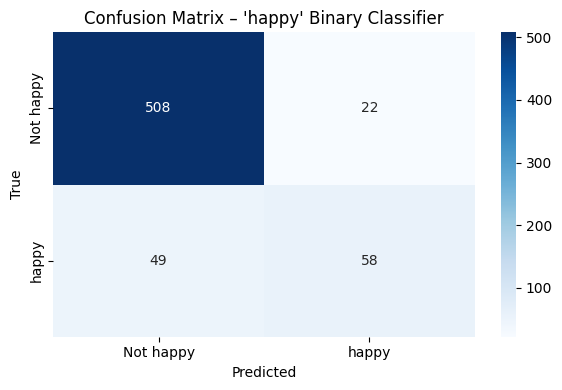

In [7]:
selector2 = ColumnTransformer(
  [
    ("pick_happy", "passthrough", top_feats)
  ],
  remainder="drop"
)

happy_pipe2 = Pipeline([
    ("select", selector2),
    ("scaler", scaler),
    ("clf", MLPClassifier(
        hidden_layer_sizes=(128, 64),
        activation="relu",
        alpha=1e-3,
        learning_rate_init=1e-3,
        solver="adam",
        max_iter=1000,
        random_state=42,
        verbose=False
    ))
])

happy_pipe2.fit(x_train, y_train)

y_pred2 = happy_pipe2.predict(x_test)
print("=== Happy Binary Classification Report ===")
print(classification_report(y_test, y_pred2, target_names=["not happy","happy"]))

cm2 = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(
    cm2, 
    annot=True, 
    fmt="d", 
    cmap="Blues",
    xticklabels=[f"Not {"happy"}", "happy"],
    yticklabels=[f"Not {"happy"}", "happy"]
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title(f"Confusion Matrix – '{"happy"}' Binary Classifier")
plt.tight_layout()
plt.show()


In [8]:
# ("clf", XGBClassifier(
#         use_label_encoder=False,
#         eval_metric="logloss",
#         scale_pos_weight=(y_train==0).sum()/(y_train==1).sum()
#     ))
# ("clf", MLPClassifier(
#         hidden_layer_sizes=(128, 64),
#         activation="relu",
#         alpha=1e-3,
#         learning_rate_init=1e-3,
#         solver="adam",
#         max_iter=1000,
#         random_state=42,
#         verbose=False
#     ))